In [ ]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [39]:
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sys
import os
import sklearn
import pandas as pd
import utils as utl
import seaborn as sns
from KDEpy import FFTKDE
from custom_bijectors import Marginal_transforms
from FlowDists import CopulaFlow, RealNVPFlow
from sklearn import preprocessing as preproc
from UCI_data_preproc.gas import GAS
from UCI_data_preproc.power import POWER
from UCI_data_preproc.miniboone import MINIBOONE
from UCI_data_preproc.hepmass import HEPMASS

In [46]:
# Load UCI  dataset
data_trn_native=MINIBOONE().trn.x
data_tst_native=MINIBOONE().tst.x

# splitting the data into training, testing and validation sets
data_trn_native,data_vld_native,_ = utl.splitData(data_trn_native,[0.75,0.25])

n_samps_trn,n_dims = data_trn_native.shape
n_samps_vld,_ = data_vld_native.shape
n_samps_tst,_ = data_tst_native.shape

print(f'Number of Training samples = {n_samps_trn}, Number of dimensions = {n_dims}')
print(f'Number of Validation samples = {n_samps_vld}, Number of dimensions = {n_dims}')
print(f'Number of Testing samples = {n_samps_tst}, Number of dimensions = {n_dims}')

# removing the outliers from training data
data_trn_native, bounds = utl.removeOutliers(data_trn_native)
data_vld_native,_ = utl.removeOutliers(data_vld_native,bounds)
data_tst_native,_ = utl.removeOutliers(data_tst_native,bounds)

Number of Training samples = 22183, Number of dimensions = 43
Number of Validation samples = 7373, Number of dimensions = 43
Number of Testing samples = 3648, Number of dimensions = 43
Removinng 306 outliers out of total 22183 datapoints.
Removinng 68 outliers out of total 7373 datapoints.
Removinng 41 outliers out of total 3648 datapoints.


In [47]:
# preprocessing data
# power transforming the data
data_trn,pw_trans,pw_trans_params=utl.power_transform(data_trn_native)
data_vld,_,_=utl.power_transform(data_vld_native,pw_trans)
data_tst,_,_=utl.power_transform(data_tst_native,pw_trans)

C:\Users\tewar\Anaconda3\envs\myPythonEnv_updated\lib\site-packages\scipy\stats\_morestats.py:924: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\tewar\Anaconda3\envs\myPythonEnv_updated\lib\site-packages\scipy\optimize\_optimize.py:2769: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\tewar\Anaconda3\envs\myPythonEnv_updated\lib\site-packages\scipy\optimize\_optimize.py:2308: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\tewar\Anaconda3\envs\myPythonEnv_updated\lib\site-packages\scipy\optimize\_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\tewar\Anaconda3\envs\myPythonEnv_updated\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, 

In [48]:
# downsampling the training data to have a representative samps for non-parametric marginal
data_trn_native_sorted=tf.sort(data_trn_native,axis=0)
n_trn=data_trn_native.shape[0]
emp_cdfs=tf.constant([i/n_trn for i in range(n_trn)])
req_cdfs=tf.constant([i/999 for i in range(1000)])
sort_idx=tf.searchsorted(emp_cdfs,req_cdfs,side='right')-1
data_trn_native_samps_sorted = tf.gather(data_trn_native_sorted,sort_idx,axis=0)

In [50]:
# LEARNING MARGINAL DISTRIBUTION
n_comps = 100
logits = tf.Variable(tf.zeros((n_dims, n_comps)),name='log_mix_props')
mus = tf.Variable(tf.transpose(data_trn[np.random.choice(data_trn.shape[0],n_comps,replace=False),:]),name='mus')
log_sigs = tf.Variable(-tf.ones((n_dims,n_comps)), name='scale')
train_vars=[logits, mus, log_sigs]

# Defining the training step
@tf.function
def train_step(x_batch):
    with tf.GradientTape() as tape:
        kde= tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logits),
                                   components_distribution=tfd.Normal(loc=mus, scale=tf.exp(log_sigs)))
        neg_gmm_ll = -tf.reduce_mean(kde.log_prob(x_batch))
    grads = tape.gradient(neg_gmm_ll, train_vars)

    if not tf.math.reduce_any(tf.math.is_nan(grads)) or  tf.math.reduce_any(tf.math.is_inf(grads)):
        optimizer.apply_gradients(zip(grads, train_vars)) #updating the gmc parameters
    return neg_gmm_ll

# Defining the validation step
@tf.function
def valid_step(x_batch):
    kde= tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logits),
                           components_distribution=tfd.Normal(loc=mus,
                                                              scale=tf.exp(log_sigs)))
    neg_gmm_ll = -tf.reduce_mean(kde.log_prob(x_batch))
    return neg_gmm_ll

optimizer = tf.optimizers.Adam(learning_rate=1E-3)
max_iters,print_interval,batch_size_trn,batch_size_vld=50000,100,200,500

neg_ll_trn = np.empty(max_iters)  
neg_ll_trn[:] = np.NaN
neg_ll_vld = np.empty(max_iters)  
neg_ll_vld[:] = np.NaN
patience,last_vld_err=0,float('inf')

ts = time.time() # start time
# Optimization iterations
for itr in np.arange(max_iters):
    if patience>5: break # early termination 
    np.random.seed(itr)
    # Executing a training step
    samps_idx = np.random.choice(data_trn.shape[0],batch_size_trn,replace=False)
    x_batch_trn = tf.gather(data_trn,samps_idx)
    neg_ll_trn[itr] = train_step(x_batch_trn).numpy()
    # Printing results every 100 iteration    
    if tf.equal(itr%print_interval,0) or tf.equal(itr,0):
        if data_vld is not None: 
            s = min(batch_size_vld,data_vld.shape[0])
            samps_idx = np.random.choice(data_vld.shape[0],s,replace=False)
            x_batch_vld = tf.gather(data_vld,samps_idx)
            neg_ll_vld[itr] = valid_step(x_batch_vld).numpy()
            if neg_ll_vld[itr]>last_vld_err: 
                patience+=1
            else:
                patience=0
            last_vld_err=neg_ll_vld[itr]

        time_elapsed = np.round(time.time()-ts,1)
        print(f'@ Iter:{itr}, \
                Training error: {np.round(neg_ll_trn[itr],3)}, \
                Validation error: {np.round(neg_ll_vld[itr],3)}, \
                Time Elapsed: {time_elapsed} s')    

# marginal gmms in transformed sapce
marginals_gmm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logits),
                           components_distribution=tfd.Normal(loc=mus,
                                                              scale=tf.exp(log_sigs)))
# marginals in native space
marginals_native=tfd.TransformedDistribution(distribution=marginals_gmm,bijector=pw_trans)


@ Iter:0,                 Training error: 186553312.0,                 Validation error: 175088736.0,                 Time Elapsed: 0.8 s
@ Iter:100,                 Training error: 180053424.0,                 Validation error: 139018592.0,                 Time Elapsed: 2.1 s
@ Iter:200,                 Training error: 175196352.0,                 Validation error: 130210280.0,                 Time Elapsed: 3.4 s
@ Iter:300,                 Training error: 94517240.0,                 Validation error: 133348608.0,                 Time Elapsed: 4.7 s
@ Iter:400,                 Training error: 98618928.0,                 Validation error: 84008544.0,                 Time Elapsed: 6.0 s
@ Iter:500,                 Training error: 96005472.0,                 Validation error: 81036768.0,                 Time Elapsed: 7.3 s
@ Iter:600,                 Training error: 68085896.0,                 Validation error: 89243592.0,                 Time Elapsed: 8.6 s
@ Iter:700,                 T

@ Iter:5900,                 Training error: 2572896.75,                 Validation error: 2653556.75,                 Time Elapsed: 80.3 s
@ Iter:6000,                 Training error: 2156414.0,                 Validation error: 2422189.75,                 Time Elapsed: 81.5 s
@ Iter:6100,                 Training error: 2754747.75,                 Validation error: 2330914.0,                 Time Elapsed: 82.9 s
@ Iter:6200,                 Training error: 2258526.75,                 Validation error: 2349441.0,                 Time Elapsed: 84.1 s
@ Iter:6300,                 Training error: 1998506.0,                 Validation error: 2385450.25,                 Time Elapsed: 85.4 s
@ Iter:6400,                 Training error: 1828847.75,                 Validation error: 2018557.625,                 Time Elapsed: 86.9 s
@ Iter:6500,                 Training error: 2043823.5,                 Validation error: 1945971.125,                 Time Elapsed: 88.2 s
@ Iter:6600,           

@ Iter:11800,                 Training error: 149151.391,                 Validation error: 132776.266,                 Time Elapsed: 159.7 s
@ Iter:11900,                 Training error: 129243.562,                 Validation error: 99250.688,                 Time Elapsed: 161.1 s
@ Iter:12000,                 Training error: 112000.461,                 Validation error: 108584.219,                 Time Elapsed: 162.7 s
@ Iter:12100,                 Training error: 109208.648,                 Validation error: 96249.086,                 Time Elapsed: 164.2 s
@ Iter:12200,                 Training error: 112225.648,                 Validation error: 101746.703,                 Time Elapsed: 165.6 s
@ Iter:12300,                 Training error: 91526.078,                 Validation error: 80125.508,                 Time Elapsed: 167.1 s
@ Iter:12400,                 Training error: 99017.195,                 Validation error: 79405.664,                 Time Elapsed: 168.6 s
@ Iter:12500

@ Iter:17700,                 Training error: 1166.203,                 Validation error: 1355.726,                 Time Elapsed: 240.4 s
@ Iter:17800,                 Training error: 1279.43,                 Validation error: 1275.416,                 Time Elapsed: 241.8 s
@ Iter:17900,                 Training error: 1092.493,                 Validation error: 1218.752,                 Time Elapsed: 243.3 s
@ Iter:18000,                 Training error: 1011.934,                 Validation error: 1044.084,                 Time Elapsed: 244.7 s
@ Iter:18100,                 Training error: 1057.142,                 Validation error: 1050.895,                 Time Elapsed: 246.0 s
@ Iter:18200,                 Training error: 908.35,                 Validation error: 1010.436,                 Time Elapsed: 247.4 s
@ Iter:18300,                 Training error: 976.202,                 Validation error: 894.518,                 Time Elapsed: 248.9 s
@ Iter:18400,                 Training 

@ Iter:23800,                 Training error: 45.525,                 Validation error: 52.84,                 Time Elapsed: 326.4 s
@ Iter:23900,                 Training error: 40.519,                 Validation error: 47.504,                 Time Elapsed: 327.9 s
@ Iter:24000,                 Training error: 39.08,                 Validation error: 40.966,                 Time Elapsed: 329.3 s
@ Iter:24100,                 Training error: 37.637,                 Validation error: 38.732,                 Time Elapsed: 330.6 s
@ Iter:24200,                 Training error: 42.764,                 Validation error: 39.435,                 Time Elapsed: 332.0 s
@ Iter:24300,                 Training error: 33.793,                 Validation error: 33.198,                 Time Elapsed: 333.4 s
@ Iter:24400,                 Training error: 34.901,                 Validation error: 31.397,                 Time Elapsed: 334.9 s
@ Iter:24500,                 Training error: 29.844,           

@ Iter:30000,                 Training error: 2.939,                 Validation error: 3.463,                 Time Elapsed: 412.9 s
@ Iter:30100,                 Training error: 2.887,                 Validation error: 3.334,                 Time Elapsed: 414.3 s
@ Iter:30200,                 Training error: 3.436,                 Validation error: 3.052,                 Time Elapsed: 415.8 s
@ Iter:30300,                 Training error: 2.758,                 Validation error: 2.847,                 Time Elapsed: 417.5 s
@ Iter:30400,                 Training error: 2.985,                 Validation error: 2.984,                 Time Elapsed: 418.9 s
@ Iter:30500,                 Training error: 2.744,                 Validation error: 2.849,                 Time Elapsed: 420.3 s
@ Iter:30600,                 Training error: 2.847,                 Validation error: 2.811,                 Time Elapsed: 421.8 s
@ Iter:30700,                 Training error: 2.685,                 Validat

@ Iter:36300,                 Training error: 1.389,                 Validation error: 1.386,                 Time Elapsed: 502.4 s
@ Iter:36400,                 Training error: 1.35,                 Validation error: 1.423,                 Time Elapsed: 503.8 s
@ Iter:36500,                 Training error: 1.442,                 Validation error: 1.408,                 Time Elapsed: 505.2 s
@ Iter:36600,                 Training error: 1.406,                 Validation error: 1.39,                 Time Elapsed: 506.5 s
@ Iter:36700,                 Training error: 1.36,                 Validation error: 1.412,                 Time Elapsed: 507.9 s
@ Iter:36800,                 Training error: 1.368,                 Validation error: 1.41,                 Time Elapsed: 509.3 s
@ Iter:36900,                 Training error: 1.331,                 Validation error: 1.398,                 Time Elapsed: 510.6 s
@ Iter:37000,                 Training error: 1.355,                 Validation 

@ Iter:42600,                 Training error: 1.349,                 Validation error: 1.352,                 Time Elapsed: 590.8 s
@ Iter:42700,                 Training error: 1.317,                 Validation error: 1.355,                 Time Elapsed: 592.2 s
@ Iter:42800,                 Training error: 1.369,                 Validation error: 1.361,                 Time Elapsed: 593.6 s
@ Iter:42900,                 Training error: 1.358,                 Validation error: 1.346,                 Time Elapsed: 594.9 s
@ Iter:43000,                 Training error: 1.364,                 Validation error: 1.357,                 Time Elapsed: 596.3 s
@ Iter:43100,                 Training error: 1.363,                 Validation error: 1.353,                 Time Elapsed: 597.7 s
@ Iter:43200,                 Training error: 1.363,                 Validation error: 1.374,                 Time Elapsed: 599.0 s
@ Iter:43300,                 Training error: 1.398,                 Validat

@ Iter:48900,                 Training error: 1.323,                 Validation error: 1.333,                 Time Elapsed: 677.7 s
@ Iter:49000,                 Training error: 1.356,                 Validation error: 1.332,                 Time Elapsed: 679.2 s
@ Iter:49100,                 Training error: 1.298,                 Validation error: 1.33,                 Time Elapsed: 681.0 s
@ Iter:49200,                 Training error: 1.318,                 Validation error: 1.345,                 Time Elapsed: 682.4 s
@ Iter:49300,                 Training error: 1.358,                 Validation error: 1.347,                 Time Elapsed: 683.8 s
@ Iter:49400,                 Training error: 1.326,                 Validation error: 1.324,                 Time Elapsed: 685.1 s
@ Iter:49500,                 Training error: 1.354,                 Validation error: 1.356,                 Time Elapsed: 686.4 s
@ Iter:49600,                 Training error: 1.36,                 Validatio

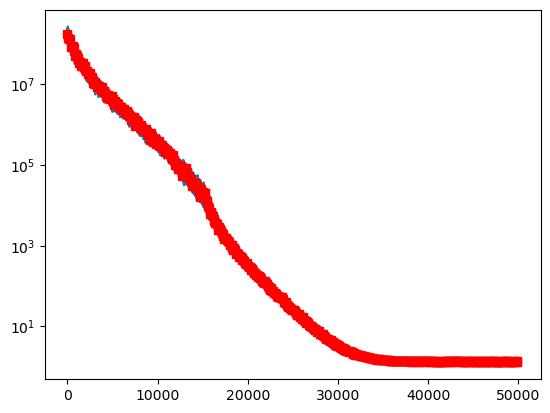

In [52]:
plt.semilogy(neg_ll_trn)
plt.semilogy(neg_ll_vld,'rs')

In [53]:
marginal_params={'marg_gmm_params':(logits.numpy(), mus.numpy(), log_sigs.numpy()),
                 'pw_trans_params': pw_trans_params,
                 'sorted_native_samps': data_trn_native_samps_sorted.numpy()}
jbl.dump(marginal_params,'saved_models/marginal_params_MINIBOONE')

['saved_models/marginal_params_MINIBOONE']

In [ ]:
vv=[]
for i in range(100):
    idx=np.random.choice(data_vld_native.shape[0],100)
    dd = data_vld_native[idx,:]
    marg_log_prob=tf.reduce_mean(tf.reduce_sum(marignals_native.log_prob(dd),axis=1))
    vv.append(marg_log_prob.numpy())
    
[np.mean(vv), np.median(vv)]

In [ ]:
data_trn_native_sorted=tf.sort(data_trn_native,axis=0)
n_trn=data_trn_native.shape[0]
emp_cdfs=tf.constant([i/n_trn for i in range(n_trn)])
req_cdfs=tf.constant([i/999 for i in range(1000)])
sort_idx=tf.searchsorted(emp_cdfs,req_cdfs,side='right')-1
data_trn_native_samps_sorted = tf.gather(data_trn_native_sorted,sort_idx,axis=0).numpy()

In [ ]:
marginal_params=jbl.load('saved_models/marginal_params_POWER')
marginal_params['sorted_native_smaps']=data_trn_native_samps_sorted

In [ ]:
marginal_params.keys()

In [ ]:
print(n_trn)
sort_idx
tf.searchsorted(emp_cdfs,tf.constant([1.]))

In [ ]:
n_tst=data_tst_native.shape[0]
samps_margs=marignals_native.sample(n_tst).numpy()

In [ ]:
idx=5
out=plt.hist(data_tst_native[:,idx].reshape(-1,1),100);
plt.hist(samps_margs[:,idx].reshape(-1,1),out[1],alpha=0.5);

In [ ]:
ndims=8
# instantiating copula flow object
nvp_obj=RealNVPFlow(ndims,batch_norm=True, num_bijectors=5)
# learn the marginals

nll_nvp=nvp_obj.fit_dist(data_trn_native,
            data_valid=data_vld_native,
            optimizer = tf.optimizers.Adam(learning_rate=1E-3), 
            max_iters = 10000, 
            batch_size = 100, 
            print_interval=100)

In [ ]:
plt.plot(nll_nvp[0])
plt.plot(nll_nvp[1],'rs')

In [ ]:
n_tst=data_tst_native.shape[0]
samps_rnvp=nvp_obj.flow_rnvp.sample(n_tst).numpy()

In [ ]:
idx=0
samps_cnvp_base_flow=cpf_obj.base_flow.sample(n_tst).numpy()
out=plt.hist(samps_cnvp_base_flow[:,idx].reshape(-1,1),100);

In [ ]:
from custom_bijectors import rankbased_CDF
samps=cpf_obj.base_flow.sample(1000)
bijec_kde=rankbased_CDF(samps)
# combining the base bijection with marignal bijections (KDE and GMM)    
copula_flow = tfd.TransformedDistribution(distribution=cpf_obj.base_flow.distribution,
                                         bijector=tfb.Chain([cpf_obj.bijector_final, bijec_kde, cpf_obj.base_flow.bijector]))



In [ ]:
idx=0
sc.stats.cramervonmises_2samp(samps_cnvp[:,idx], samps_rnvp[:,idx])

In [ ]:
sc.__version__

In [ ]:
uu1=nvp_obj.flow_rnvp.sample(10000).numpy()
uu2=copula_flow.sample(10000).numpy()
idx=1
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.hist(uu1[:,idx].reshape(-1,1),50);
plt.subplot(132)
plt.hist(uu2[:,idx].reshape(-1,1),50);
plt.subplot(133)
plt.hist(u_vld[:10000,idx].reshape(-1,1),50);

In [ ]:
u_vld_subset=u_vld[1000:1004,:]*0.001
ll1=nvp_obj.flow_rnvp.log_prob(u_vld_subset)
ll2=copula_flow.log_prob(u_vld_subset)
plt.plot(ll1)
plt.plot(ll2)

In [ ]:
final_flow_nvp=tfd.TransformedDistribution(
    distribution=nvp_obj.flow_rnvp.distribution,
    bijector=tfb.Chain([pw_trans,nvp_obj.flow_rnvp.bijector]))
data_tst_sample=data_tst_native[:1000,:]
ll_nvp=final_flow_nvp.log_prob(data_tst_sample)
np.median(ll_nvp)

In [ ]:
cpf_obj.gen_copula_flow()

In [ ]:
# uu=np.random.rand(100,8).astype('float32')
# ld1=cpf_obj.bijec_rank.inverse_log_det_jacobian(uu)
# ld2=cpf_obj.bijec_rank._inverse_log_det_jacobian_exp(uu)
# plt.plot(ld1,ld2,'k.')
ss=cpf_obj.base_flow.sample(10000).numpy()
uu1=cpf_obj.bijec_rank.forward(ss)
uu2=cpf_obj.bijec_rank.kde.cdf(ss)
uu2.shape

In [ ]:
idx=7
plt.plot(ss[:,idx],uu1[:,idx],'k.')
plt.plot(ss[:,idx],uu2[:,idx],'r.')

In [ ]:
plt.hist(ss[:,idx].reshape(-1,1),50);

In [ ]:
cpf_obj.bijec_rank._inverse_log_det_jacobian_exp(uu)

In [ ]:
ss=kde.sample(5)
lp=kde.log_prob(ss)
tf.reduce_sum(lp,axis=1)

In [ ]:
tf.math.log(uu[1:,:]-uu[:-1,:]) - tf.math.log(ss[1:,:]-ss[:-1,:])

In [ ]:
plt.plot(nll_cpf[0],'k.')
plt.plot(nll_cpf[1],'r.')

In [ ]:
cpf_obj.gen_copula_flow(num_samps=100000)


In [ ]:
uu=cpf_obj.copula_flow.sample(10000).numpy()
idx=7
plt.subplot(121)
plt.hist(uu[:,idx].reshape(-1,1),50);
plt.subplot(122)
plt.hist(np.random.rand(10000).reshape(-1,1),50);


In [ ]:
ndims=8
# instantiating copula flow object
nvpu_obj=RealNVPFlowUnit(ndims,num_bijectors=5)
# learn the marginals
nvpu_obj.learn_marginals(data_trn,method='gmm')

In [ ]:
nll_nvpu=nvpu_obj.fit_dist(data_trn,
            data_valid=data_vld,
            optimizer = tf.optimizers.Adam(learning_rate=1E-3), 
            max_iters = 2000, 
            batch_size = 100, 
            print_interval=100)

In [ ]:
plt.plot(nll_nvpu[0])
plt.plot(nll_nvpu[1],'rs')

In [ ]:
from custom_bijectors import rankbased_CDF
num_samps=100000
samps=nvpu_obj.flow_rnvp.sample(num_samps)
bijec_rank=rankbased_CDF(samps)
        
# comning the base bijection with kde bijectopm    
bijec_composite = tfb.Chain([bijec_rank,nvpu_obj.flow_rnvp.bijector])
copula_flow = tfd.TransformedDistribution(distribution=nvpu_obj.flow_rnvp.distribution,
                                         bijector=bijec_composite)

In [ ]:
uu1=nvpu_obj.flow_rnvp.sample(10000).numpy()
uu2=copula_flow.sample(10000).numpy()

In [ ]:
idx1,idx2=0,3
plt.subplot(121)
plt.plot(uu1[:,idx1],uu1[:,idx2],'k.')
plt.subplot(122)
plt.plot(uu2[:,idx1],uu2[:,idx2],'r.')

In [ ]:
idx=0
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.hist(uu1[:,idx].reshape(-1,1),50);
plt.subplot(132)
plt.hist(uu2[:,idx].reshape(-1,1),50);
plt.subplot(133)
plt.hist(np.random.rand(10000).reshape(-1,1),50);

In [ ]:
u_tst = nvpu_obj.marg_bijector.inverse(data_trn[:5,:])
bijec_rank.inverse_log_det_jacobian(u_tst)

In [ ]:
from custom_bijectors import rankbased_CDF
base_dist=tfd.Independent(tfd.Beta(concentration0=[2,2],concentration1=[2,2]),reinterpreted_batch_ndims=1)
# base_dist=tfd.MultivariateNormalTriL(loc=[2.0,2.0],scale_tril=tf.eye(2))
ubeta=base_dist.sample(10000).numpy()

bijec_rank=rankbased_CDF(ubeta)
ubeta.shape


In [ ]:
ubeta=base_dist.sample(10000).numpy()
uuu=bijec_rank.forward(ubeta).numpy()
plt.hist(uuu,50);

In [ ]:
trans_dist=tfd.TransformedDistribution(distribution=base_dist,bijector=bijec_rank)
u_uniform=np.random.rand(100,2).astype('float32')
plt.plot(base_dist.log_prob(u_uniform))
plt.plot(trans_dist.log_prob(u_uniform))

In [ ]:
tf.math.log(2.)

In [ ]:
from custom_bijectors import rankbased_CDF
base_dist=tfd.Independent(tfd.Beta(concentration0=[2.5,5],concentration1=[2.5,5]),reinterpreted_batch_ndims=1)
samps_beta=base_dist.sample(10000).numpy()
bijec_rank=rankbased_CDF(samps_beta)
trans_dist=tfd.TransformedDistribution(distribution=base_dist,bijector=bijec_rank)

u=[np.linspace(0.001,0.999,100).reshape(-1,1) for _ in range(2)]
u=np.concatenate(u,axis=1)
ll1=base_dist.log_prob(u)
ll2=trans_dist.log_prob(u)
plt.plot(ll1)
plt.plot(ll2)


In [ ]:
plt.plot(bijec_rank.x_arr[1,:],bijec_rank.u_arr[1,:],'k')
plt.plot(bijec_rank.x_arr[1,:],tfd.Beta(concentration0=5,concentration1=5).cdf(bijec_rank.x_arr[1,:]))

In [ ]:
u_tst = nvpu_obj.marg_bijector.inverse(data_tst[:10,:])
# ll1_tst=nvpu_obj.flow_rnvp.log_prob(u_tst)
ll2_tst=copula_flow.log_prob(u_tst)

In [ ]:
plt.plot(ll1_tst)
plt.plot(ll2_tst)

In [ ]:
uu=nvpu_obj.flow_rnvp.sample(10000).numpy()
idx=2
plt.hist(uu[:,idx].reshape(-1,1),10);

In [ ]:
cpf_obj.gen_copula_flow(phase='sampling')
final_flow_cf=tfd.TransformedDistribution(
    distribution=cpf_obj.copula_flow.distribution,
    bijector=tfb.Chain([pw_trans,cpf_obj.marg_bijector,cpf_obj.copula_flow.bijector]))
data_tst_sample=data_tst_native[:1000,:]
ll_cf=final_flow_cf.log_prob(data_tst_sample)
np.nanmedian(ll_cf)

In [ ]:
plt.plot(ll_nvp[:100])
plt.plot(ll_cf[:100])

In [ ]:
final_flow_cnvp=tfd.TransformedDistribution(
    distribution=nvpu_obj.flow_rnvp.distribution,
    bijector=tfb.Chain([pw_trans,nvpu_obj.marg_bijector,nvpu_obj.flow_rnvp.bijector]))
data_tst_sample=data_tst_native[:10000,:]
ll_cnvp=final_flow_cnvp.log_prob(data_tst_sample)
np.nanmedian(ll_cnvp)

In [ ]:
from custom_bijectors import KDE_transform
samps=nvpu_obj.flow_rnvp.sample(1000)
bijec_kde=KDE_transform(samps)
# comning the base bijection with kde bijectopm    
copula_flow = tfd.TransformedDistribution(distribution=nvpu_obj.flow_rnvp.distribution,
                                         bijector=tfb.Chain([pw_trans,nvpu_obj.marg_bijector,bijec_kde,nvpu_obj.flow_rnvp.bijector]))
# data_tst_sample=data_tst_native[:10000,:]
# ll_cf=copula_flow.log_prob(data_tst_sample)
# np.nanmedian(ll_cf)
# ss1=nvpu_obj.flow_rnvp.sample(10000).numpy()
# ss2=copula_flow.sample(10000).numpy()

In [ ]:
data_tst_sample=data_trn_native[100:200,:]
ll_cnvp=final_flow_cnvp.log_prob(data_tst_sample)
ll_cf=copula_flow.log_prob(data_tst_sample)

In [ ]:
plt.plot(ll_cnvp)
plt.plot(ll_cf)

In [ ]:
plt.hist((ll_cnvp-ll_nvp).numpy().reshape(-1,1),50);
plt.xlim(-20,20)

In [ ]:
plt.subplot(121)
plt.hist((ll_cnvp-ll_nvp).numpy().reshape(-1,1),50);
plt.subplot(122)
plt.plot(ll_nvp[:100])
plt.plot(ll_cnvp[:100])

In [ ]:
s_nvp=final_flow_nvp.sample(10000).numpy()
s_cnvp=final_flow_cnvp.sample(10000).numpy()

In [ ]:
idx=7
plt.figure(figsize=[10,5])
plt.subplot(121)
out=plt.hist(data_tst_native[:10000,idx].reshape(-1,1),50);
plt.hist(s_nvp[:,idx].reshape(-1,1),out[1],alpha=0.5);
plt.subplot(122)
out=plt.hist(data_tst_native[:10000,idx].reshape(-1,1),50);
plt.hist(s_cnvp[:,idx].reshape(-1,1),out[1],alpha=0.5);



In [ ]:
ll_nvp=nvp_obj.flow_rnvp.log_prob(data_vld).numpy()
ll_cnvp=nvpu_obj.log_prob(data_vld).numpy()

In [ ]:
plt.hist((-ll_nvp+ll_cnvp).reshape(-1,1),100);
# plt.plot(ll_cnvp)
plt.xlim(-4,75)

In [ ]:
nvpf_obj = RealNVPFlow(ndims,BatchNorm=True,num_bijectors=5)
nll_nvpf=nvpf_obj.fit_dist(data_trn,
            data_valid=data_vld,
            optimizer = tf.optimizers.Adam(learning_rate=1E-3), 
            max_iters = 2000, 
            batch_size = 100, 
            print_interval=50)

In [ ]:
plt.plot(nll_nvpf[0])
plt.plot(nll_nvpf[1],'rs')

In [ ]:
nll_cpf=cpf_obj.fit_dist(data_trn,
                 data_valid=data_vld,
                 optimizer = tf.optimizers.Adam(learning_rate=1E-3), 
                 max_iters = 1000, 
                 batch_size = 100, 
                 print_interval=50)


In [ ]:
plt.plot(nll_cpf[0])
plt.plot(nll_cpf[1],'rs-')

out=cpf_obj.gen_copula_flow()

In [ ]:
cpf_obj.gen_copula_flow()
final_bijec=tfb.Chain([cpf_obj.marg_bijector,cpf_obj.copula_flow.bijector])
final_flow=tfd.TransformedDistribution(
    distribution=cpf_obj.copula_flow.distribution,
    bijector=final_bijec)

In [ ]:
idx=np.random.choice(data_vld.shape[0],1000,replace=False)
data_vld=data_vld[idx,:]

In [ ]:
ll_1=final_flow.log_prob(data_vld)
ll_2=nvpf_obj.flow_rnvp.log_prob(data_vld)

In [ ]:
# plt.plot(ll_1)
plt.plot(ll_2[30:100]-ll_1[30:100],'ko-')
np.mean(ll_1[30:100]-ll_2[30:100])

In [ ]:
ss1= nvpf_obj.flow_rnvp.sample(10000)
ss2=final_flow.sample(10000)

In [ ]:
idx=7
plt.subplot(121)
out=plt.hist(ss1[:,idx].numpy().reshape(-1,1),50);
plt.hist(data_tst[:10000,idx].reshape(-1,1),out[1],alpha=0.7);

plt.subplot(122)
out=plt.hist(ss2[:,idx].numpy().reshape(-1,1),50);
plt.hist(data_tst[:10000,idx].reshape(-1,1),out[1],alpha=0.7);

In [ ]:
ss1.shape

In [ ]:
# data=np.random.randn(1000,4)
# n_data_points=data.shape[0]
# # gathering extreme points for each dimension (to be included in the training set)
# extreme_points_ids=np.concatenate([np.argmin(data,axis=0), np.argmax(data,axis=0)])
# np.unique(extreme_points_ids)

In [ ]:
cpf_samps=pd.DataFrame(xx,columns=[f'd{i}' for i in range(ndims)])
nvp_samps=pd.DataFrame(yy,columns=[f'd{i}' for i in range(ndims)])

In [ ]:
pairs=[(9,7),(17,2),(8,3),(11,21),(11,3),(2,3)]
fig,axs=plt.subplots(2,3,figsize=(10,6))

for i in range(len(pairs)):
    id1,id2=pairs[i]
    r,c=divmod(i,3)
    plt.sca(axs[r,c])
    sns.kdeplot(data=cpf_samps,x=f'd{id1}',y=f'd{id2}',fill=True,color='b')
    plt.plot(data_vld[:,id1],data_vld[:,id2],'rs',markersize=4)
    plt.xlim(-2.5,2.5)
    plt.ylim(-2.5,2.5)
plt.tight_layout(pad=1.0)


In [ ]:
nknots,nsamps,ndims=10000,10,4
x_arr = tf.sort(np.random.randn(ndims,nknots).astype('float32'),axis=1)
u_arr = tf.repeat(tf.reshape(tf.linspace(0,1,nknots),(1,-1)),ndims,axis=0)
u_arr = tf.cast(u_arr,dtype=tf.float32)

# temp array of lower and upper bounds along each dimensions
x_lb = tf.repeat(tf.reshape(tf.gather(x_arr,0,axis=1),(-1,1)),nsamps,axis=1)
x_ub = tf.repeat(tf.reshape(tf.gather(x_arr,nknots-1,axis=1),(-1,1)),nsamps,axis=1)

# interpolation points
x=np.random.randn(ndims,nsamps).astype('float32')
idx=tf.searchsorted(x_arr,x)
# taking care of the points outside the boundaries
x=tf.where(idx==nknots,x_ub,x)
x=tf.where(idx==0,x_lb,x)
idx=tf.where(idx==nknots,nknots-1,idx)
idx=tf.where(idx==0,1,idx)

# gathering the x-grid values
xb = tf.gather(x_arr,idx,axis=1,batch_dims=1)
xa = tf.gather(x_arr,idx-1,axis=1,batch_dims=1)
# gathering the y-grid values
ub = tf.gather(u_arr,idx,axis=1,batch_dims=1)
ua = tf.gather(u_arr,idx-1,axis=1,batch_dims=1)

# obtaining the weights
w1=(xb-x)/(xb-xa)
w2=(x-xa)/(xb-xa)
# getting the linear interpolation
u=w1*ua+w2*ub
print(u)

In [ ]:
log_slope=tf.math.log((ub-ua)/(xb-xa))
tf.reduce_sum(log_slope,axis=0)